### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.stattools import adfuller  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf, seasonal_plot, month_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

### Reading in Data

In [2]:
bus = pd.read_csv('../brianna_folder/datasets/clean_bus_avg_ridership.csv')

In [3]:
bus.set_index(pd.DatetimeIndex(bus['month_beginning']), inplace=True)
bus.drop(columns=['month_beginning'], inplace=True)

In [4]:
bus.head()

,route_id,route_name,avg_weekday_rides,avg_saturday_rides,avg_sunday-holiday_rides,month_total
month_beginning,,,,,,
2001-01-01,1,Indiana/Hyde Park,6982.6,0.0,0.0,153617
2001-01-01,2,Hyde Park Express,1000.0,0.0,0.0,22001
2001-01-01,3,King Drive,21406.5,13210.7,8725.3,567413
2001-01-01,4,Cottage Grove,22432.2,17994.0,10662.2,618796
2001-01-01,6,Jackson Park Express,18443.0,13088.2,7165.6,493926


In [5]:
# Redefining dataframe to pre-pandemic ridership.

In [6]:
bus_pre_covid = bus[bus.index < '2020-03-01'].copy()

In [7]:
bus_pre_covid = bus_pre_covid.resample('MS', closed ='left').mean()

In [8]:
# Finding seasonality with acf and pacf

In [9]:
bus_pre_covid['1st_diff_total'] = bus_pre_covid['month_total'].diff(1)

In [10]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [11]:
interpret_dftest(adfuller(bus_pre_covid['month_total']))

Test Statistic   -1.928662
p-value           0.318700
dtype: float64

In [12]:
interpret_dftest(adfuller(bus_pre_covid['1st_diff_total'].dropna()))

Test Statistic   -3.558628
p-value           0.006603
dtype: float64

In [13]:
decomp_month_diff = seasonal_decompose(bus_pre_covid['1st_diff_total'].dropna(), period = 12)

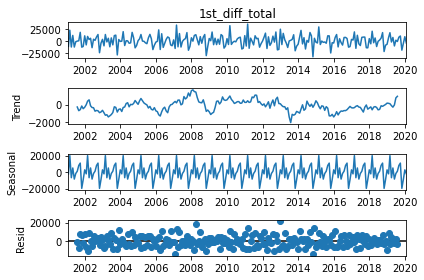

In [14]:
decomp_month_diff.plot();

In [15]:
decomp_month = seasonal_decompose(bus_pre_covid['month_total'], period = 12)

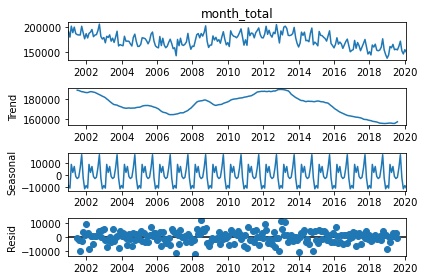

In [16]:
decomp_month.plot();

In [66]:
bus_pre_covid['lag_1'] = bus_pre_covid['1st_diff_total'].shift(1)
bus_pre_covid['lag_2'] = bus_pre_covid['1st_diff_total'].shift(2)
bus_pre_covid['lag_3'] = bus_pre_covid['1st_diff_total'].shift(3)

In [68]:
bus_pre_covid.corr()

,avg_weekday_rides,avg_saturday_rides,avg_sunday-holiday_rides,month_total,1st_diff_total,lag_1,lag_3,seasonal_12,time,lag_2
avg_weekday_rides,1.000000,0.763921,0.551060,0.897992,0.265468,0.290508,-0.213090,0.215254,-0.397501,0.142254
avg_saturday_rides,0.763921,1.000000,0.799238,0.815621,0.101417,0.215720,-0.045601,0.099098,-0.483201,0.114950
avg_sunday-holiday_rides,0.551060,0.799238,1.000000,0.674178,0.142985,0.211061,-0.032020,0.120241,-0.065477,0.077238
month_total,0.897992,0.815621,0.674178,1.000000,0.426061,0.183211,-0.029549,0.347320,-0.377970,0.154212
1st_diff_total,0.265468,0.101417,0.142985,0.426061,1.000000,-0.284878,-0.213831,0.738885,-0.004563,-0.043374
lag_1,0.290508,0.215720,0.211061,0.183211,-0.284878,1.000000,-0.044296,-0.091908,-0.001543,-0.284004
lag_3,-0.213090,-0.045601,-0.032020,-0.029549,-0.213831,-0.044296,1.000000,-0.247988,-0.003423,-0.282874
seasonal_12,0.215254,0.099098,0.120241,0.347320,0.738885,-0.091908,-0.247988,1.000000,-0.009818,-0.097540
time,-0.397501,-0.483201,-0.065477,-0.377970,-0.004563,-0.001543,-0.003423,-0.009818,1.000000,-0.007211
lag_2,0.142254,0.114950,0.077238,0.154212,-0.043374,-0.284004,-0.282874,-0.097540,-0.007211,1.000000


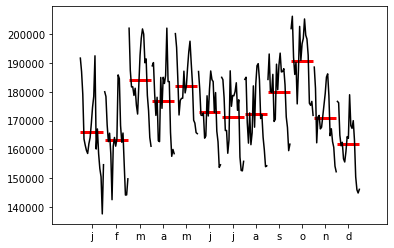

In [70]:
month_plot(bus_pre_covid['month_total']);
plt.savefig('./assets/monthplot_bus.png')

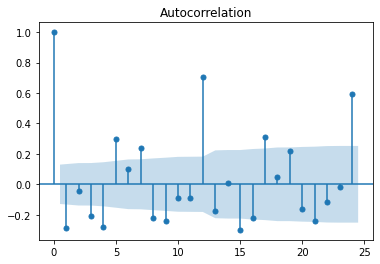

In [17]:
plot_acf(bus_pre_covid['1st_diff_total'].dropna(), lags=24);

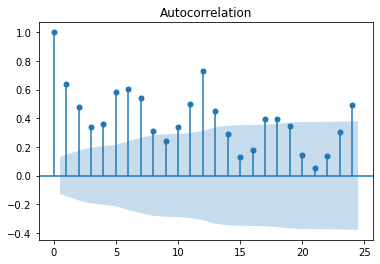

In [18]:
plot_acf(bus_pre_covid['month_total'], lags=24);

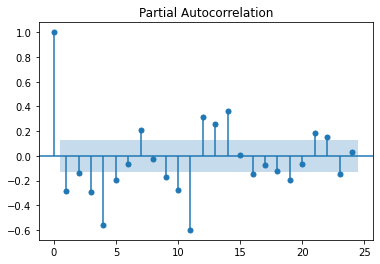

In [19]:
plot_pacf(bus_pre_covid['1st_diff_total'].dropna(), lags=24);

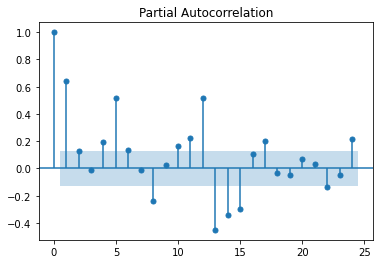

In [20]:
plot_pacf(bus_pre_covid['month_total'], lags=24);

In [21]:
# There is yearly seasonality and a downward trend.

In [22]:
# Setting up dataframe for fitting.

In [23]:
# Creating columns for notable lags.

# Monthly
bus_pre_covid['lag_1'] = bus_pre_covid['1st_diff_total'].shift(1)

# Quarterly
bus_pre_covid['lag_3'] = bus_pre_covid['1st_diff_total'].shift(3)

# Yearly.
bus_pre_covid['seasonal_12'] = bus_pre_covid['1st_diff_total'].shift(12)

# Creating monthly index.
bus_pre_covid['time'] = range(0, bus_pre_covid.shape[0])

In [49]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(bus_pre_covid.drop(columns = ['1st_diff_total']),
                                                    bus_pre_covid['1st_diff_total'],
                                                    test_size = 0.25,
                                                    shuffle=False)

In [50]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(172, 8)
(58, 8)
(172,)
(58,)


In [51]:
# Linear Timeseries

In [52]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

y_train = y_train[X_train.index]

In [53]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [54]:
lm = sm.OLS(y_train, X_train)

In [55]:
lm_results = lm.fit()

In [56]:
lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         1st_diff_total   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     45.24
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           2.84e-36
Time:                        14:46:37   Log-Likelihood:                -1624.2
No. Observations:                 159   AIC:                             3266.
Df Residuals:                     150   BIC:                             3294.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -5.155e+04   1.02e+04     -5.051      0.000   -7.17e+04   -3.14e+04
avg_weekday_rides           -6.4241      3.166     -2.029      0.044     -12.680      -0.169
avg_saturday_rides         -10.5573      4.155     -2.541      0.012     -18.768      -2.347
avg_sunday-holiday_rides     1.5094      3.761      0.401      0.689      -5.922       8.941
month_total                  0.7808      0.137      5.700      0.000       0.510       1.051
lag_1                       -0.2678      0.050     -5.401      0.000      -0.366      -0.170
lag_3                       -0.1596      0.056     -2.853      0.005      -0.270      -0.049
seasonal_12                  0.4456      0.058      7.644      0.000       0.330       0.561
time                       -20.1524     13.470     -1.496      0.137     -46.767       6.462
==============================================================================
Omnibus:                        0.998   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                0.895
Skew:                           0.183   Prob(JB):                        0.639
Kurtosis:                       2.979   Cond. No.                     3.37e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
lm_results.predict(X_test)

month_beginning
2015-05-01     6474.135987
2015-06-01   -13052.264764
2015-07-01     5556.399427
2015-08-01    -2980.555915
2015-09-01    10315.266697
2015-10-01    10886.690072
2015-11-01   -21213.084684
2015-12-01     3875.976880
2016-01-01    -8049.436042
2016-02-01    -2760.965808
2016-03-01    15537.385732
2016-04-01    -9719.064137
2016-05-01     1422.429481
2016-06-01    -8110.799514
2016-07-01    -6200.857202
2016-08-01    -2588.616388
2016-09-01      456.084096
2016-10-01     4319.543252
2016-11-01   -18952.564282
2016-12-01    -8121.878297
2017-01-01    -5046.547828
2017-02-01    -6611.579541
2017-03-01    12249.513646
2017-04-01   -19547.325345
2017-05-01     6542.114316
2017-06-01   -12417.305571
2017-07-01    -9652.065504
2017-08-01      -60.963062
2017-09-01    -2291.998674
2017-10-01     6383.468749
2017-11-01   -12724.631760
2017-12-01   -14113.683660
2018-01-01    -2076.170475
2018-02-01   -12138.800792
2018-03-01    11681.519721
2018-04-01   -18277.705120
2018-05-01  

In [58]:
r2_score(y_test, lm_results.predict(X_test))

0.5503194117045818

In [59]:
mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

6909.267677079803

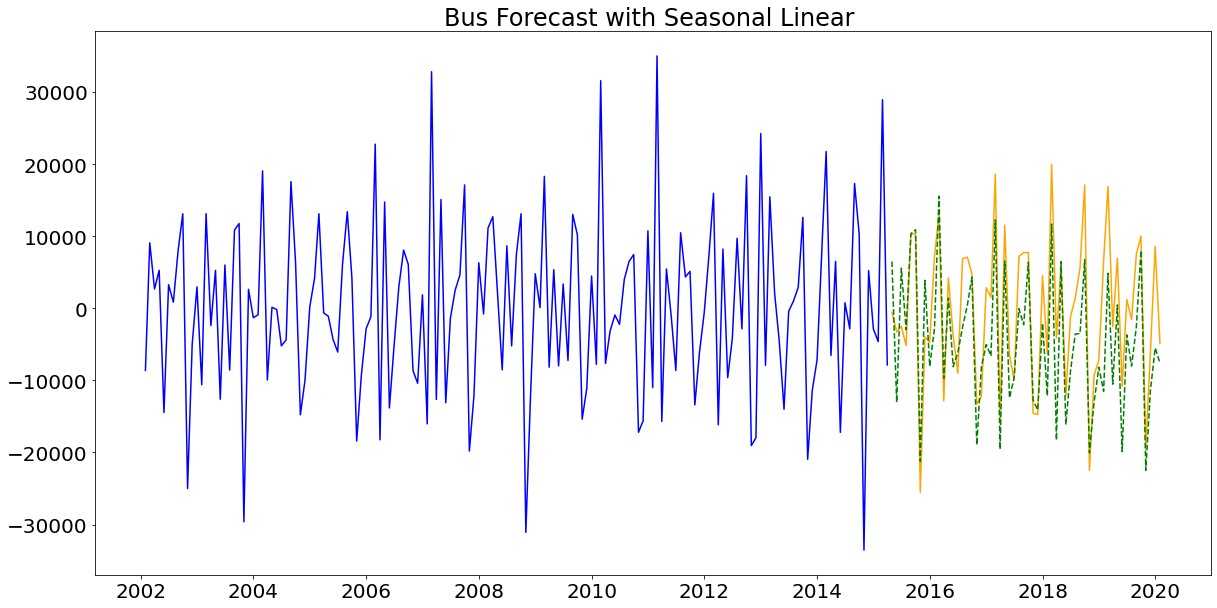

In [63]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'green', ls='--')

# Set label.
plt.title(label = 'Bus Forecast with Seasonal Linear ', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.savefig('./assets/linear_forecast_bus.png')